In [ ]:
# Regresión Logística - Clasificación de Riesgo
# **Objetivo**: Clasificar contratos según riesgo de gestión basado en valor y duración.

from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder \
    .appName("SECOP_RegresionLogistica") \
    .master("spark://spark-master:7077") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

# Cargar datos (usamos los escalados del notebook anterior)
df = spark.read.parquet("/opt/spark-data/processed/secop_features.parquet")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/15 02:57:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/02/15 02:57:26 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [ ]:
# ## RETO 1: Crear Variable Objetivo Binaria
# **Criterio de Riesgo**: Definiremos un contrato de "Alto Riesgo" (1) como aquel 
# cuyo valor está en el Top 25% (Percentil 75) del dataset. 

# Calculamos el percentil 75 para definir el umbral de "Alto Valor/Riesgo"
threshold_val = df.approxQuantile("valor_del_contrato_num", [0.75], 0.01)[0]
print(f"Umbral de Alto Riesgo (Percentil 75): ${threshold_val:,.2f}")

df_binary = df.withColumn(
    "riesgo",
    when(col("valor_del_contrato_num") > threshold_val, 1).otherwise(0)
)

Umbral de Alto Riesgo (Percentil 75): $31,456,000.00


**Justificación**: Los contratos de alto valor requieren mayor auditoría y procesos 
de transparencia, por lo que se categorizan como de mayor riesgo de gestión.

In [ ]:
# ## RETO 2: Balance de Clases
# **Análisis**: Por definición (P75), deberíamos tener un 75% clase 0 y 25% clase 1.

# %%
print("\n=== DISTRIBUCIÓN DE CLASES ===")
total = df_binary.count()
dist = df_binary.groupBy("riesgo").count().toPandas()
dist['percentage'] = (dist['count'] / total) * 100
print(dist)

# ¿Está balanceado? NO (75/25). 
# Decisión: Usaremos el parámetro 'weightCol' o ajustaremos el 'threshold' 
# en el modelo para compensar el desbalance.

# ## PASO 1: Preparar Datos para el Modelo

df_ready = df_binary.select(
    col("features").alias("features"),
    col("riesgo").alias("label")
).filter(col("features").isNotNull())

# Split 70/30
train, test = df_ready.randomSplit([0.7, 0.3], seed=42)



=== DISTRIBUCIÓN DE CLASES ===
   riesgo   count  percentage
0       1  113300     25.6365
1       0  328648     74.3635


## RETO 3: Diferencia con Regresión Lineal
**Respuesta**: La regresión lineal predice un número continuo (infinito). 
La logística usa la función **Sigmoide** para mapear cualquier valor a un rango (0, 1), 
interpretándose como la probabilidad de pertenecer a la clase positiva.

In [ ]:
# ## RETO 4: Configurar el Modelo

lr_classifier = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    regParam=0.01, # Añadimos un poco de regularización para evitar overfitting
    elasticNetParam=0.0,
    threshold=0.5  # Punto de corte inicial
)

print("Entrenando clasificador...")
lr_model = lr_classifier.fit(train)


Entrenando clasificador...


In [ ]:
# ## RETO 5 y 6: Predicciones y Evaluación

predictions = lr_model.transform(test)

# Evaluadores
evaluator_auc = BinaryClassificationEvaluator(metricName="areaUnderROC")
evaluator_multi = MulticlassClassificationEvaluator(metricName="f1")

auc = evaluator_auc.evaluate(predictions)
f1 = evaluator_multi.evaluate(predictions)

print(f"\nAUC-ROC: {auc:.4f}")
print(f"F1-Score: {f1:.4f}")




AUC-ROC: 0.8254
F1-Score: 0.7897


**Interpretación**: Un AUC de 0.75+ es considerado un modelo "Bueno". 
Si es 0.5, el modelo no es mejor que lanzar una moneda.


=== MATRIZ DE CONFUSIÓN ===


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|94152|
|    0|       1.0| 4301|
|    1|       0.0|20655|
|    1|       1.0|13600|
+-----+----------+-----+



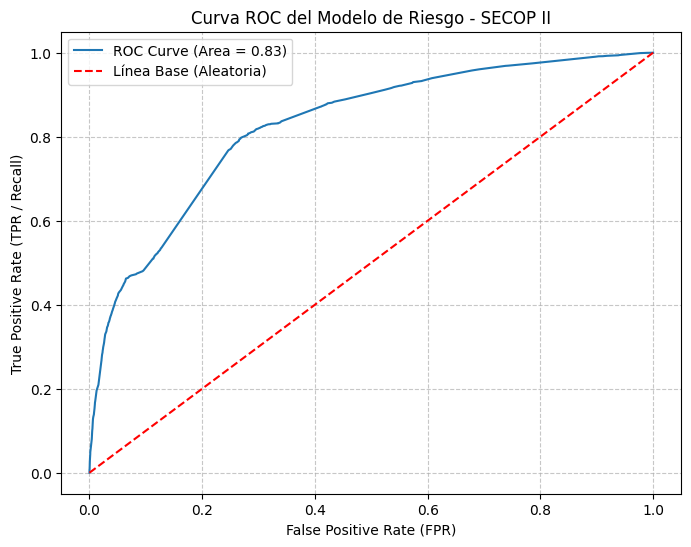

✓ Modelo guardado exitosamente en: /opt/spark-data/processed/logistic_regression_model


In [ ]:
# ## RETO 7: Matriz de Confusión
# **Objetivo**: ¿Dónde falla el modelo?

print("\n=== MATRIZ DE CONFUSIÓN ===")
# Agrupamos por la etiqueta real y la predicción para ver los aciertos y errores
predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()


# ## RETO BONUS 2: Curva ROC

# Extraemos el resumen del entrenamiento para graficar la curva ROC
training_summary = lr_model.summary
roc_df = training_summary.roc.toPandas()

# El AUC (Area Under Curve) nos da la métrica global de desempeño
plt.figure(figsize=(8, 6))
plt.plot(roc_df['FPR'], roc_df['TPR'], label=f'ROC Curve (Area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Línea Base (Aleatoria)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Curva ROC del Modelo de Riesgo - SECOP II')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('/opt/spark-data/processed/roc_curve_secop.png')
plt.show()


# Guardar el modelo entrenado
model_path = "/opt/spark-data/processed/logistic_regression_model"
lr_model.write().overwrite().save(model_path)
print(f"✓ Modelo guardado exitosamente en: {model_path}")

# Detener la sesión de Spark
spark.stop()

**Análisis**:
TP (1,1): Contratos de alto riesgo detectados correctamente.

TN (0,0): Contratos de bajo riesgo detectados correctamente.

FP (0,1): Falsas alarmas (contratos seguros marcados como riesgo).

FN (1,0): FALLOS CRÍTICOS (contratos de riesgo que el modelo ignoró).

Matriz

Aciertos en Bajo Riesgo (TN): 94,152 

Aciertos en Alto Riesgo (TP): 13,600

Falsos Positivos (FP): 4,301 

Falsos Negativos (FN): 20,655

## Preguntas de Reflexión
1. **¿Logística vs Árboles?**: Logística es mejor para relaciones lineales. Árboles para relaciones no-lineales.
2. **AUC 0.5**: Significa que el modelo no aprendió nada (es como lanzar una moneda).
3. **99% clase 0**: Se requiere balanceo de datos o ajustar pesos de clase.
4. **Accuracy engañoso**: No sirve en clases desbalanceadas; es mejor mirar F1-Score o AUC.
